In [1]:
!nvidia-smi

Mon Jan 30 07:47:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      2MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            On   | 00000000:00:05.0 Off |                    0 |
| N/A   

In [ ]:
import sys
sys.path.append('..')

In [2]:
import os
os.environ['TOKENIZERS_PARALLELISM']='true'
os.environ['CUDA_VISIBLE_DEVICES']='2'

In [3]:
import re
import os
import torch
import json
import numpy as np
import pandas as pd
import seaborn as sns
import transformers
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from transformers import T5Tokenizer, T5TokenizerFast, T5ForConditionalGeneration
from transformers.tokenization_utils import PreTrainedTokenizer
from transformers.tokenization_utils_fast import PreTrainedTokenizerFast
from typing import Callable, Union, Tuple
from tqdm.notebook import tqdm
from collections import Counter
from torch import nn
from catalyst import dl
from catalyst.callbacks.periodic_loader import PeriodicLoaderCallback
from langdetect import detect
from easse.sari import corpus_sari
from rouge import Rouge 

from utils.dataset_utils import extract_com8text_from_tgt, extract_text8docs_from_src
from utils.dataset_utils import EditDataset, get_tgt, get_src, COM_SEP, TEXT_SEP_SRC, TEXT_SEP_TGT, DOCS_SEP
from utils.dataset_utils import ExplainDataset, get_tgt_explain, get_src_explain
from utils.metrics_utils import PeerEditMetricsCallback, PeerExplainMetricsCallback
from utils.config import Config


DOCS_DIR = 'data'
PAGES_DIR = 'data'

In [4]:
CONFIG = Config()
CONFIG.seed = 1337

In [5]:
import random

random.seed(CONFIG.seed)
os.environ['PYTHONHASHSEED'] = str(CONFIG.seed)
np.random.seed(CONFIG.seed)
torch.manual_seed(CONFIG.seed)
torch.cuda.manual_seed(CONFIG.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

## Data preparing

In [6]:
mp = json.load(open(r"../data/column_mapper.json"))

train = pd.read_json(r'../data/new_train.json')
train.set_axis(mp.values(), axis='columns', inplace=True)

test = pd.read_json(r'../data/new_test.json')
test.set_axis(mp.values(), axis='columns', inplace=True)

val = pd.read_json(r'../data/new_val.json')
val.set_axis(mp.values(), axis='columns', inplace=True)
val1 = val.sample(600)

In [7]:
train.head()

,obj_id,old_text,new_text,comment,docs,diff,title,search_queries,counter_found_docs,section_name,is_good,docs_processed
0,1005,"In rural regions of Germany, especially the Ha...","In rural regions of Germany, especially the Ha...",/* Germany */ grammar,"Apr 30, 2020 — Depending on whom you ask, May ...","this opportunity to party,",May Day,"[May Day Germany this opportunity to party,]",[27],Germany,True,"DOC0: Apr 30, 2020 — Depending on whom you ask..."
1,55,"""This is the new WikiPedia!"" \n-HomePage, the ...","""This is the new WikiPedia!"" \n-HomePage, the ...",Added subpage,English: Results of the 1929 New York City ald...,\n*/New York City Board of Aldermen,John M Wolfson,[John M Wolfson \n*/New York City Board of Ald...,"[10, 4]",,True,DOC0: English: Results of the 1929 New York Ci...
2,2329,"Ares (Ancient Greek: , Μodern Greek: Άρης ) i...","Ares (Ancient Greek: , Μodern Greek: Άρης ) i...",repaired link to 'masculinity' ~~~~,"Apr 7, 2014 — Let's explore the essence of mas...","masculinity, integrity, and personal courage.",Ares,"[Ares masculinity, integrity, and personal cou...",[30],,True,"DOC0: Apr 7, 2014 — Let's explore the essence ..."
3,17206,Peter Velhorn (born 24 November 1932) is a Ger...,Peter Velhorn (24 November 1932 – 20 July 2016...,"Passed away 2016, look at German article",Peter Velhorn (24 November 1932 – 20 July 2016...,– 20 July 2016,Peter Velhorn,[Peter Velhorn – 20 July 2016],[23],,True,DOC0: Peter Velhorn (24 November 1932 – 20 Jul...
4,47,"Michael Palin was educated at Birkdale School,...","Michael Palin was educated at Birkdale School,...",/* Early career */ added info,"Michael Palin, Nightingale House, in Clapham, ...",", Graeme Garden, Bill Oddie and Jonathan Lynn",Michael Palin,"[Michael Palin Early career , Graeme Garden, ...",[29],Early career,True,"DOC0: Michael Palin, Nightingale House, in Cla..."


In [8]:
CONFIG.src_max_len = 1024
CONFIG.tgt_max_len = 128
CONFIG.pretrained = 't5-small'
CONFIG.batch_size = 4

tokenizer = T5TokenizerFast.from_pretrained(CONFIG.pretrained, model_max_length=CONFIG.src_max_len)

In [9]:
idx = 1
el_idx = train.iloc[idx]

docs = el_idx['docs_processed']
comment = el_idx['comment']
old_text = el_idx['old_text']
new_text = el_idx['new_text']

print(f'Old text: {old_text}\n\n')
print(f'New text: {new_text}\n\n')
print(f'Comment: {comment}\n\n')
print(f'Docs: {docs}\n\n')

src = get_src_explain(el_idx)
tgt = get_tgt_explain(el_idx)

print(f'Src: {src}\n\n')
print(f'Tgt: {tgt}\n\n')

Old text: "This is the new WikiPedia!" 
-HomePage, the first ever article created on Wikipedia, created by office.bomis.com on Mon, 15 Jan 2001 19:27:13 



Interested in Chicago and urban history, and other things. 

SUBPAGES (Excl. Sandbox):
*/Chicago aldermanic notability
*/Louis B. Anderson
*/Chicago City Council since 1923
*/Town of Chicago

"FORMER" SUBPAGES (content moved elsewhere, now serving as redirects):
*/Notabilitymandering
*/List of Chicago aldermen since 1923
*/Chicago aldermanic elections before 1923


New text: "This is the new WikiPedia!" 
-HomePage, the first ever article created on Wikipedia, created by office.bomis.com on Mon, 15 Jan 2001 19:27:13 



Interested in Chicago and urban history, and other things. 

SUBPAGES (Excl. Sandbox):
*/Chicago aldermanic notability
*/Louis B. Anderson
*/Chicago City Council since 1923
*/Town of Chicago
*/New York City Board of Aldermen

"FORMER" SUBPAGES (content moved elsewhere, now serving as redirects):
*/Notabilitymandering

**Make dataset**

In [10]:
ds_train = ExplainDataset(train, tokenizer, CONFIG, text_to_lower=True, comment_to_lower=True)
ds_val = ExplainDataset(val1, tokenizer, CONFIG, text_to_lower=True, comment_to_lower=True)
ds_val_full = ExplainDataset(val, tokenizer, CONFIG, text_to_lower=True, comment_to_lower=True)

**Len distribution**

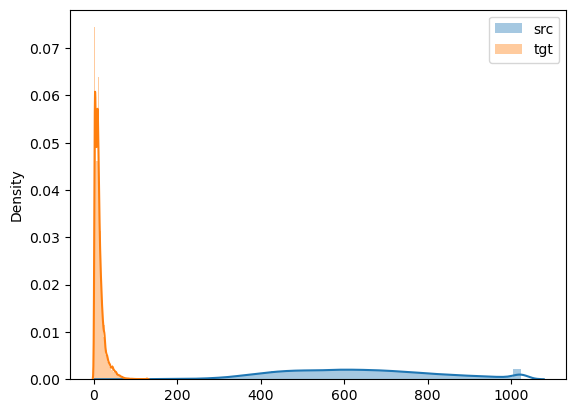

In [11]:
arr_src = []
arr_tgt = []
for src_q, tgt_q in ds_train:
    arr_src.append(len(src_q['input_ids']))
    arr_tgt.append(len(tgt_q['input_ids']))

sns.distplot(arr_src, label='src');
plt.legend();
sns.distplot(arr_tgt, label='tgt');
plt.legend();

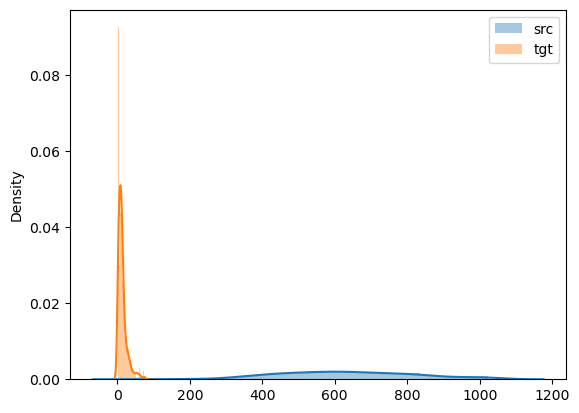

In [12]:
arr_src = []
arr_tgt = []
for src_q, tgt_q in ds_val:
    arr_src.append(len(src_q['input_ids']))
    arr_tgt.append(len(tgt_q['input_ids']))

sns.distplot(arr_src, label='src');
plt.legend();
sns.distplot(arr_tgt, label='tgt');
plt.legend();

In [13]:
idx_num = 0
src_text = tokenizer.decode(ds_train[idx_num][0]['input_ids'], skip_special_tokens=True)
tgt_text = tokenizer.decode(ds_train[idx_num][1]['input_ids'], skip_special_tokens=True)

In [14]:
print(f'{src_text}\n\n{tgt_text}')

in rural regions of germany, especially the harz mountains, walpurgisnacht celebrations of pagan origin are traditionally held on the night before may day, including bonfires and the wrapping of maypoles, and young people use opportunity to party, while the day itself is used by many families to get some fresh air. motto: "tanz in den mai!" ("dance into may!"). in the rhineland, a region in the western part of germany, may 1 is also celebrated by the delivery of a tree covered in streamers to the house of a girl the night before. the tree is typically from a love interest, though a tree wrapped only in white streamers is a sign of dislike. TEXT_SEP in rural regions of germany, especially the harz mountains, walpurgisnacht celebrations of pagan origin are traditionally held on the night before may day, including bonfires and the wrapping of maypoles, and young people use this opportunity to party, while the day itself is used by many families to get some fresh air. motto: "tanz in den m

## Model training

In [15]:
loaders = {
    'train': torch.utils.data.DataLoader(ds_train, 
                                         batch_size=CONFIG.batch_size,
                                         collate_fn=lambda x: EditDataset.collate_fn(x, tokenizer, CONFIG),
                                         num_workers=4, shuffle=True),
    'valid_full': torch.utils.data.DataLoader(ds_val_full, 
                                         batch_size=CONFIG.batch_size,
                                         collate_fn=lambda x: EditDataset.collate_fn(x, tokenizer, CONFIG),
                                         num_workers=4, shuffle=False),
    'valid_subset': torch.utils.data.DataLoader(ds_val, 
                                         batch_size=CONFIG.batch_size,
                                         collate_fn=lambda x: EditDataset.collate_fn(x, tokenizer, CONFIG),
                                         num_workers=4, shuffle=False)
}

In [16]:
class ExplainModel(nn.Module):
    def __init__(self, 
                 pretrained: transformers.modeling_utils.PreTrainedModel, 
                 config: Config):
        super(ExplainModel, self).__init__()
        self.pretrained = pretrained
        

    def forward(self, 
                x: Tuple[torch.Tensor, torch.Tensor]):
        src, tgt = x
        
        tgt[tgt == 0] == -100
        
        loss = self.pretrained(
            input_ids = src,
            attention_mask = (src != 0).float(),
            labels=tgt,
        ).loss
        return loss
    
    
class Criterion(nn.Module):
    def __init__(self):
        super(Criterion, self).__init__()
        
    def forward(self, pred, tgt):
        return pred

In [17]:
model = ExplainModel(
    T5ForConditionalGeneration.from_pretrained(CONFIG.pretrained),
    CONFIG
)
CONFIG.optimizer = 'Adam(lr=0.0001)'
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

CONFIG.name = f'{CONFIG.pretrained}'
CONFIG.description = f'{CONFIG.name} p(comment | x_t, x_t+1, doc)'
CONFIG.group = "wiki_explain"

In [18]:
!rm -rf ./models/"{CONFIG.description}"

In [19]:
CONFIG.n_epochs = 40

In [20]:
METRIC_LIST = [
    'full__exact_match@1',
    'full__exact_match@5'
]   

In [ ]:
runner = dl.SupervisedRunner()

wandb_logger = dl.WandbLogger(project="interactive_lm", 
                              name=CONFIG.name, 
                              group=CONFIG.group)

runner.train(
    loaders=loaders,
    model=model,
    criterion=Criterion(),
    optimizer=optimizer,
    num_epochs=CONFIG.n_epochs,
    callbacks=[
        PeriodicLoaderCallback(
            valid_loader_key='valid_full',
            valid_metric_key='loss',
            minimize=True,
            **{'valid_full': 5}
        ),
        PeerExplainMetricsCallback(METRIC_LIST, tokenizer),
    ],
    loggers={'wandb': wandb_logger},
    logdir=f'./models/{CONFIG.description}',
    valid_loader='valid_subset',
    valid_metric='loss',
    minimize_valid_metric=True,
    verbose=True,
#     check=True,
#     cpu=True,
)

wandb: Currently logged in as: anton-sh. Use `wandb login --relogin` to force relogin


1/40 * Epoch (train):   0%|          | 0/29890 [00:00<?, ?it/s]

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


train (1/40) loss: 1.5953838284656099 | loss/mean: 1.5953838284656099 | loss/std: 0.5872764180858642 | lr: 0.0001 | momentum: 0.9


1/40 * Epoch (valid_subset):   0%|          | 0/150 [00:00<?, ?it/s]

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


valid_subset (1/40) full__exact_match@1: 0.008333 | full__exact_match@1/std: 0.053404 | full__exact_match@5: 0.021667 | full__exact_match@5/std: 0.076093 | loss: 1.319076735476653 | loss/mean: 1.319076735476653 | loss/std: 0.515034060117327 | lr: 0.0001 | momentum: 0.9
* Epoch (1/40) 


2/40 * Epoch (train):   0%|          | 0/29890 [00:00<?, ?it/s]

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


CONFIG.beam_size = 1

device = runner.engine.device
runner.model.eval()
with torch.no_grad():
    for i in [0, 1, 2]:
        src_, tgt_ = ds_train[i]
        src_inp = torch.tensor(src_['input_ids']).view(1,-1).to(runner.engine.device)
        generated = runner.model.pretrained.generate(src_inp,
                                              attention_mask=(src_inp != 0).float().to(runner.engine.device),
                                            # pad_token_id=tokenizer.pad_token_id,
                                            # bos_token_id=tokenizer.bos_token_id,
                                            # eos_token_id=tokenizer.eos_token_id,
                                              num_beams=CONFIG.beam_size,
                                              num_return_sequences=CONFIG.beam_size,
                                              max_length=1000
        )
        
        tgt_full = tokenizer.decode(tgt_['input_ids'], skip_special_tokens=True).strip()
        tgt_comment, tgt_text = extract_com8text_from_tgt(tgt_full)

        src_full = tokenizer.decode(src_['input_ids'], skip_special_tokens=True).strip()
        src_text, _ = extract_text8docs_from_src(src_full)
        
        
        print(f'\n\n----------------------------\t QUERY {i}\t ----------------------------\n')
        print(f'Src query:\n {src_text}')
        print(f'\nTgt query:\n {tgt_text}')
        print(f'\nTgt comment:\n {tgt_comment}')
        
        print(f'\n\n----------------------------\t GENERATED\t ----------------------------\n')

        pred_full = []
        pred_texts = []
        pred_comments = []
        for j in range(CONFIG.beam_size):
            to_gen = generated[j]
            gen_text = tokenizer.decode(to_gen, skip_special_tokens=True)
            com_prediction, text_prediction = extract_com8text_from_tgt(gen_text)
            
            pred_full.append(gen_text)
            pred_texts.append(text_prediction)
            pred_comments.append(com_prediction)
            
            print(f'{j} TEXT:\n{text_prediction}\n')
            print(f'{j} COMMENT:\n{com_prediction}\n\n')
        
        print('Text sari:', sari_one(src_text, tgt_text, pred_texts))
        print('Com em:', topN_diff_exact_match_one('', tgt_comment, pred_comments))
        print('Full em:', topN_diff_exact_match_one(src_full, tgt_full, pred_full))
        print('Text em:', topN_diff_exact_match_one(src_text, tgt_text, pred_texts))
        print('Rouge text:', rouge_one(src_text, tgt_text, pred_texts)['rouge-1'])